In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import the MNIST dataset
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [91]:
class Ball:
    def __init__(self, x0, r, move_func):
        self.x0 = x0
        self.r = int(np.array(r))
        self.x = np.copy(x0)
        self.t = 0
        self.move_func = move_func

    def reset(self):
        self.x = np.copy(self.x0)
        self.t = 0

    def step(self, dt):
        self.t += dt
        x = np.copy(self.x)
        self.x += dt*self.move_func(self.t, x)
        
        return self.x

    

class Image(Ball):
    def __init__(self, x0, r, move_func, size, border=2):
        super(Image, self).__init__(x0, r, move_func)
        self.size = size
        self.border = border
        self.image_dim = (size, size, 3)
        self.image = np.zeros(self.image_dim, dtype=np.uint8)
        
        x = self.compute_position_on_image(self.x)
        self.image = cv2.circle(np.zeros(self.image_dim, dtype=np.uint8), (x[0], x[1]), self.r, (255, 255, 255), -1)


    def compute_position_on_image(self, x):
        x = (x - self.border[0])/(self.border[1] - self.border[0])
        x = x*(self.size-1)
        x = x.astype(np.uint8)
        x = np.clip(x, 0, self.size-1)

        return x

    def update_image(self):
        x = self.compute_position_on_image(self.x)
        self.image = cv2.circle(np.zeros(self.image_dim, dtype=np.uint8), (x[0], x[1]), self.r, (255, 255, 255), -1)


    def display(self):
        self.update_image()
        plt.imshow(self.image)
        plt.show()

    def forward(self, dt):
        x = self.step(dt)
        self.update_image()
        return x

    def animate(self, dt, frames=100, interval=20, repeat_delay=0):
        
        self.reset()
        fig = plt.figure()
        ax = plt.axes(xlim=(0, self.size), ylim=(0, self.size))
        ax.imshow(self.image)

        def init():
            self.reset()
            ax.imshow(self.image)
            return ax,

        def update(i):
            self.forward(dt)
            ax.imshow(self.image)
            return ax,
            

        anim = FuncAnimation(fig, update, init_func=init, frames=trange(0,frames), interval=interval, repeat_delay=repeat_delay)
        # plt.show()
        anim.save('images/ODE/ball_animation.gif', writer='pillow')
        plt.close()

    def generate_samples(self, dt, frames=100, conv=False):
        self.reset()


        if frames > 0:
            if conv:
                samples = np.zeros((frames, 1, self.image_dim[0], self.image_dim[1]))

            else:
                samples = np.zeros((frames, self.image_dim[0], self.image_dim[1]))

            for i in range(frames):
                self.forward(dt)
                if conv:
                    samples[i, 0] = self.image[:,:,0]

                else:
                    samples[i] = self.image[:,:,0]

            return samples

        else:
            samples = []
            current_x = np.copy(self.x)
            while True:
                x = self.forward(dt)
                if np.linalg.norm(x - current_x) < 1E-2*dt:
                    break
                current_x = np.copy(x)
                if conv: 
                    samples.append(np.expand_dims(self.image[:,:,0], axis=0))
                else:
                    samples.append(self.image[:,:,0])
                
            return np.array(samples)


def move_fun_circle(t, x, w=1, exp_decay=1.):
    return np.exp(-exp_decay*t)*np.array([-w*np.sin(w*t), w*np.cos(w*t)], dtype=np.float32)    


In [92]:
image = Image(np.array([1., 1.], dtype=np.float64), 1, lambda t,x: move_fun_circle(t,x, w=10, exp_decay=0.01), size=28, border=(-2., 2.))
samples = image.generate_samples(0.1, frames=4000, conv=True)
# print(samples.shape)
# plt.imshow(np.squeeze(samples[0, 0]))
# plt.show()
# plt.imshow(np.squeeze(samples[-10]))
# plt.show()
# plt.imshow(np.squeeze(samples[500]))
# plt.show()
image = Image(np.array([1., 1.], dtype=np.float64), 1, lambda t,x: move_fun_circle(t,x, w=-10, exp_decay=0.01), size=28, border=(-2., 2.))
samples = np.concatenate([samples, image.generate_samples(0.1, frames=4000, conv=True)], axis=0)
# Normalize samples
samples = samples/255.
print(samples.shape)

(8000, 1, 28, 28)


In [93]:
def create_random_dataset(r_max, n_samples, size):
    samples = np.zeros((n_samples, 1, size, size))
    for i in range(n_samples):
        r = np.random.randint(r_max)
        image = np.zeros((size, size), dtype=np.uint8)
        x = np.random.randint(size, size=(2))
        image = cv2.circle(image, (x[0], x[1]), r, 255, -1)
        samples[i, 0] = image

    return samples

samples = create_random_dataset(4, 12000, 28)
samples = samples/255.

In [114]:
def train(model, dataloader_train, dataloader_test, optimizer, criterion, epochs=10, display_step=1, label=True):
    
    iterator = trange(epochs)
    losses_train = []
    losses_test = []
    for _ in iterator:
        loss_epoch = 0
        model.train()
        for i, data in enumerate(dataloader_train):
            if label:
                data, _ = data
            
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data).squeeze()
            loss = criterion(output, data.squeeze())
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            if i % display_step == 0:
                iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
            

        losses_train.append(loss_epoch/len(dataloader_train))
        model.eval()
        with torch.no_grad():
            loss_epoch = 0
            for i, data in enumerate(dataloader_test):
                if label:
                    data, _ = data
                    
                data = data.to(device)
                output = model(data).squeeze()
                loss = criterion(output, data.squeeze())
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')
            
            losses_test.append(loss_epoch/len(dataloader_test))

    return losses_train, losses_test

In [115]:
# Split train and test data using sklearn
samples_train, samples_test = train_test_split(samples, test_size=0.3, random_state=42)
# create a dataloader from the matrix of samples
train_data = torch.from_numpy(samples_train).float()
test_data = torch.from_numpy(samples_test).float()

dataloader_train = DataLoader(train_data, batch_size=64, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=64, shuffle=False)

# MLP AutoEncoder

In [116]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(
                    nn.Linear(in_features=self.height*self.width, out_features=64),
                    nn.ReLU(),
                    nn.Linear(in_features=64, out_features=self.latent_dim),
                    nn.ReLU()
        )

        self.decoder = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=64),
                    nn.ReLU(),
                    nn.Linear(in_features=64, out_features=self.height*self.width),
                    nn.Sigmoid()
        )

        print("Parameters number: ", sum([p.numel() for p in self.parameters()]))
        

    def forward(self, features):
        out = self.flatten(features)
        out = self.encoder(out)
        out = self.decoder(out)
        reconstructed = out.view(features.shape[0], self.height, self.width)
        return reconstructed


## Test with 1 and 2 dimension in the middle

In [190]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AE(height=samples.shape[-2], width=samples.shape[-1], latent_dim=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

Parameters number:  101780


In [178]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

In [179]:
losses_train, losses_test = train(model, dataloader_train, dataloader_test,
                            optimizer, criterion, epochs=50, display_step=2)

  0%|          | 0/50 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


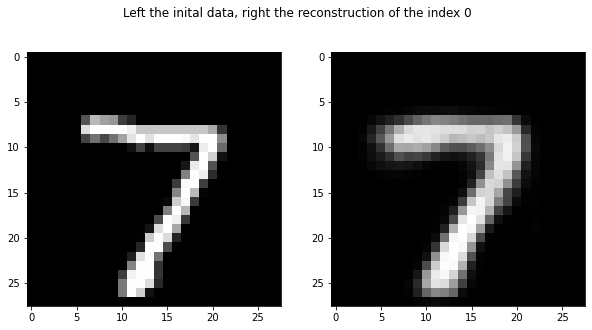

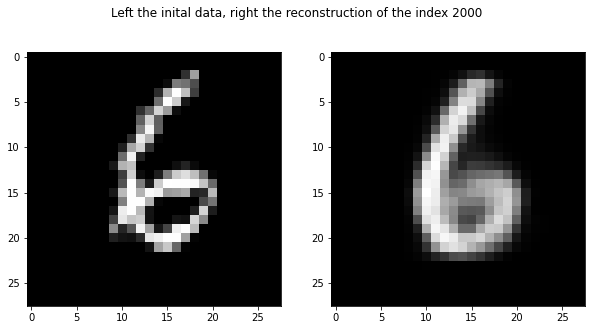

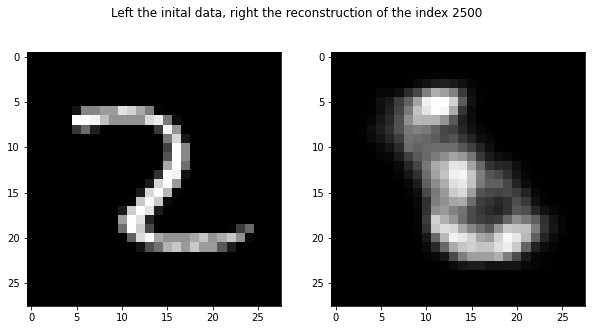

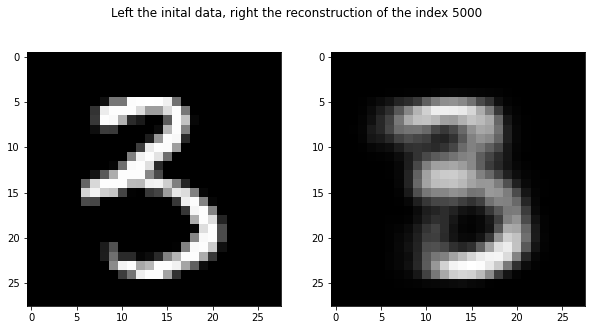

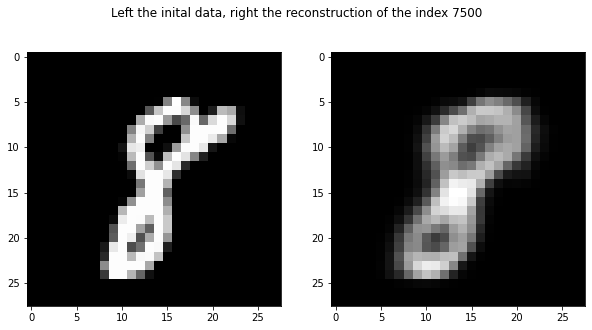

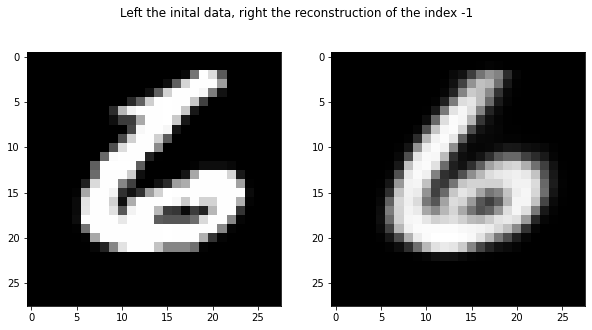

In [180]:
set_display = mnist_testset

for index in [0, len(set_display)//5, len(set_display)//4, len(set_display)//2, 3*len(set_display)//4, -1]:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Left the inital data, right the reconstruction of the index %s' % index)
    # plt.figure(figsize=(20, 10))
    ax[0].imshow(np.squeeze(set_display[index][0]), cmap='gray')
    ax[1].imshow(model(torch.tensor(set_display[index][0]).float().unsqueeze(0)).detach().numpy().squeeze(), cmap='gray')
    plt.show()

# for index in [0, len(samples)//5, len(samples)//4, len(samples)//2, 3*len(samples)//4, -1]:
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     fig.suptitle('Left the inital data, right the reconstruction of the index %s' % index)
#     # plt.figure(figsize=(20, 10))
#     ax[0].imshow(np.squeeze(samples[index]), cmap='gray')
#     ax[1].imshow(model(torch.tensor(samples[index]).float().unsqueeze(0)).detach().numpy().squeeze(), cmap='gray')
#     plt.show()

In [181]:
torch.save(model.state_dict(), 'models/AE/mnist_4_MLP_bce_ae.pt')

In [182]:
model = AE(height=samples.shape[-2], width=samples.shape[-1], latent_dim=4).to(device)
model.load_state_dict(torch.load('models/AE/mnist_4_MLP_bce_ae.pt'))

Parameters number:  101780


<All keys matched successfully>

In [187]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [191]:
samples = create_random_dataset(4, 12000, 28)
samples = samples/255.

# Split train and test data using sklearn
samples_train, samples_test = train_test_split(samples, test_size=0.3, random_state=42)
# create a dataloader from the matrix of samples
train_data = torch.from_numpy(samples_train).float()
test_data = torch.from_numpy(samples_test).float()

dataloader_train = DataLoader(train_data, batch_size=64, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=64, shuffle=False)

In [194]:
losses_train, losses_test = train(model, dataloader_train, dataloader_test,
                            optimizer, criterion, epochs=100, display_step=2, label=False)

  0%|          | 0/100 [00:00<?, ?it/s]

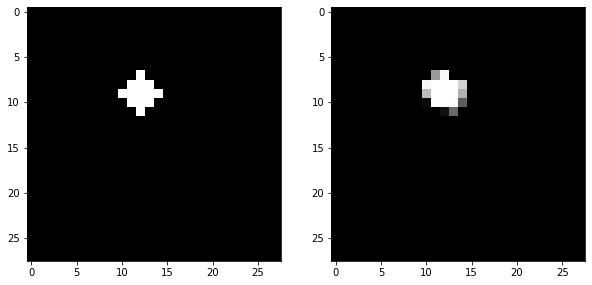

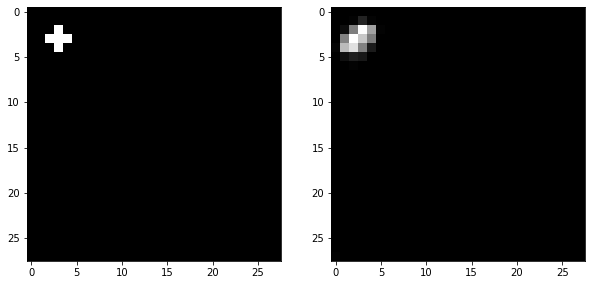

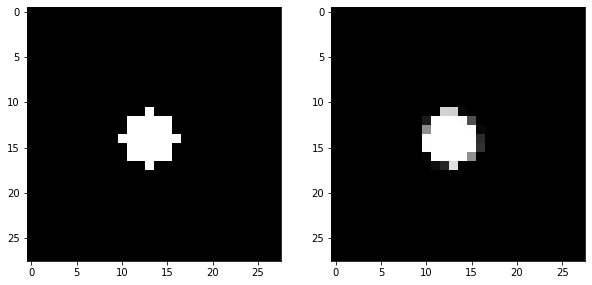

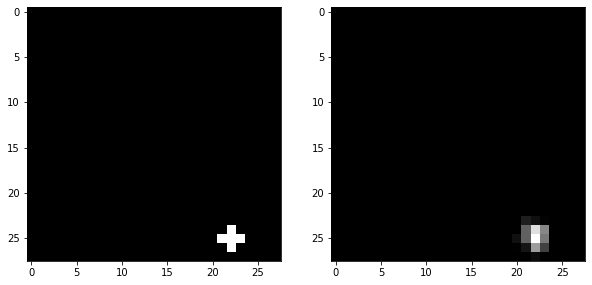

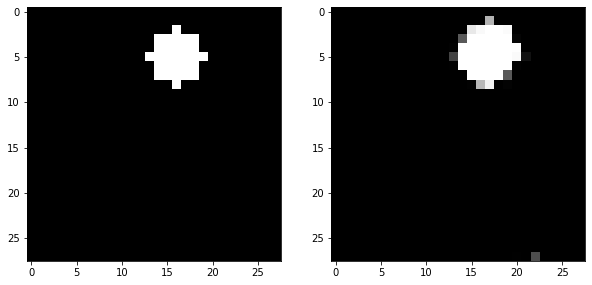

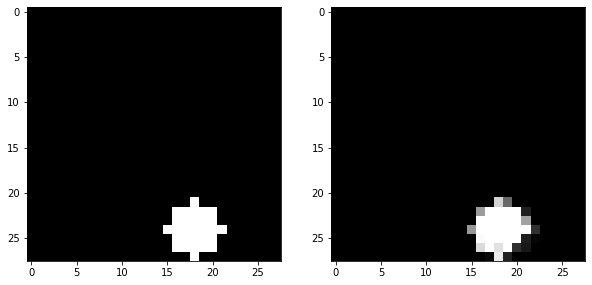

In [201]:
# set_display = mnist_train

# for index in [0, len(set_display)//5, len(set_display)//4, len(set_display)//2, 3*len(set_display)//4, -1]:
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     fig.suptitle('Left the inital data, right the reconstruction of the index %s' % index)
#     # plt.figure(figsize=(20, 10))
#     ax[0].imshow(np.squeeze(set_display[index][0]), cmap='gray')
#     ax[1].imshow(model(torch.tensor(set_display[index][0]).float().unsqueeze(0)).detach().numpy().squeeze(), cmap='gray')
#     plt.show()

for i, index in enumerate([0, len(samples)//5, len(samples)//4, len(samples)//2, 3*len(samples)//4, -1]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(np.squeeze(samples[index]), cmap='gray')
    ax[1].imshow(model(torch.tensor(samples[index]).float().unsqueeze(0)).detach().numpy().squeeze(), cmap='gray')
    plt.show()

# CNN Auto Encoder

In [63]:
class ConvAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=1),
                    nn.ReLU(),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    nn.ReLU()
                    # nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        self.encoder_linear = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=3*3*128, out_features=self.latent_dim),
                    nn.ReLU()
        )

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=3*3*128),
                    nn.ReLU()
        )
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
                    nn.Sigmoid()
        )

        # print the number of parameters in the model
        print("Number of parameters in the model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, image):
        out = self.encoder(image)
        out = self.encoder_linear(out)
        out = self.decoder_linear(out)
        out = out.view(image.shape[0], 128, 3, 3)
        out = self.decoder(out)
        return out

    def encode(self, image):
        out = self.encoder(image)
        return out

    def decode(self, latent_vector):
        out = self.decoder(latent_vector)
        return out
        

In [68]:
model = ConvAE(height=28, width=28, latent_dim=3)
torchsummary.summary(model, (1, 28, 28))

Number of parameters in the model: 222692
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 13, 13]             832
              ReLU-2           [-1, 32, 13, 13]               0
            Conv2d-3             [-1, 64, 6, 6]          32,832
              ReLU-4             [-1, 64, 6, 6]               0
            Conv2d-5            [-1, 128, 3, 3]          73,856
              ReLU-6            [-1, 128, 3, 3]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                    [-1, 3]           3,459
              ReLU-9                    [-1, 3]               0
           Linear-10                 [-1, 1152]           4,608
             ReLU-11                 [-1, 1152]               0
  ConvTranspose2d-12             [-1, 64, 7, 7]          73,792
             ReLU-13             [-1, 64, 7, 7]              

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [70]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

In [71]:
losses_train, losses_test = train(model, dataloader_train, dataloader_test, optimizer, criterion, epochs=50, display_step=4)

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


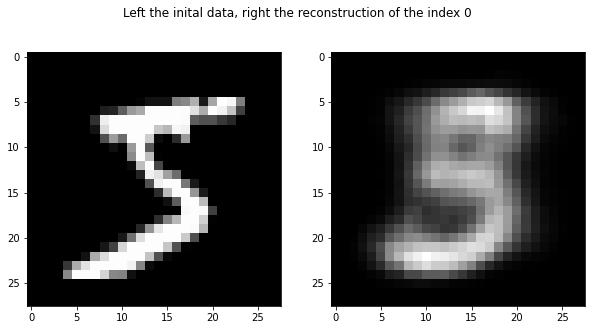

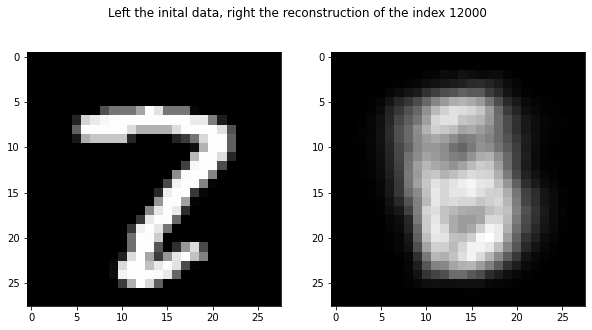

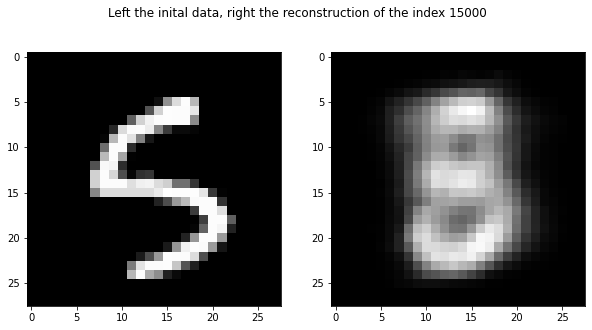

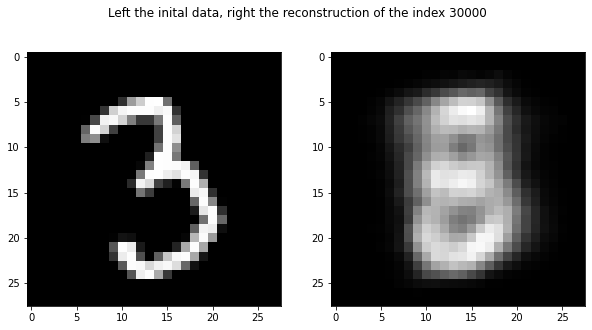

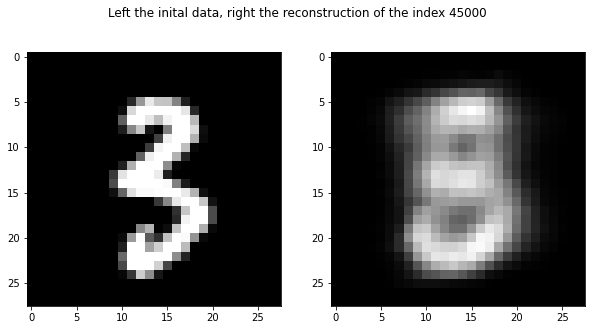

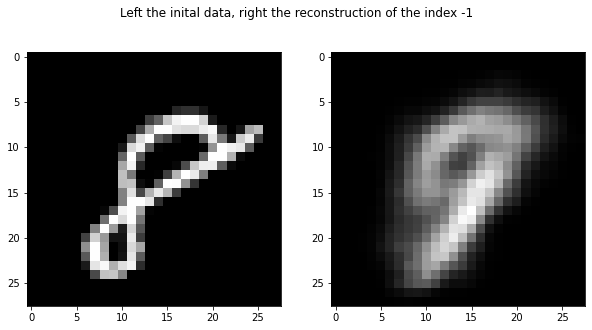

In [77]:
for index in [0, len(mnist_train)//5, len(mnist_train)//4, len(mnist_train)//2, 3*len(mnist_train)//4, -1]:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Left the inital data, right the reconstruction of the index %s' % index)
    # plt.figure(figsize=(20, 10))
    ax[0].imshow(np.squeeze(mnist_train[index][0]), cmap='gray')
    ax[1].imshow(model(torch.tensor(mnist_train[index][0]).float().unsqueeze(0)).detach().numpy().squeeze(), cmap='gray')
    plt.show()

# for index in [0, len(samples)//5, len(samples)//4, len(samples)//2, 3*len(samples)//4, -1]:
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     fig.suptitle('Left the inital data, right the reconstruction of the index %s' % index)
#     # plt.figure(figsize=(20, 10))
#     ax[0].imshow(np.squeeze(samples[index]), cmap='gray')
#     ax[1].imshow(model(torch.tensor(samples[index]).float().unsqueeze(0)).detach().numpy().squeeze(), cmap='gray')
#     plt.show()
    

In [72]:
# save the MNIST pre-trained model
torch.save(model.state_dict(), 'models/AE/mnist_3_conv_ae.pt')

In [85]:
model = ConvAE(height=28, width=28, latent_dim=3)
# model.load_state_dict(torch.load('models/AE/mnist_conv_ae.pt'))
model.load_state_dict(torch.load('models/AE/mnist_3_conv_ae.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [79]:
# Split train and test data using sklearn
samples_train, samples_test = train_test_split(samples, test_size=0.3, random_state=42)
# create a dataloader from the matrix of samples
train_data = torch.from_numpy(samples_train).float()
test_data = torch.from_numpy(samples_test).float()

dataloader_train_ball = DataLoader(train_data, batch_size=64, shuffle=True)
dataloader_test_ball = DataLoader(test_data, batch_size=64, shuffle=False)

In [86]:
losses_train, losses_test = train(model, dataloader_train_ball, dataloader_test_ball, optimizer, criterion, epochs=50, display_step=4, label=False)

  0%|          | 0/50 [00:00<?, ?it/s]

In [88]:
torch.save(model.state_dict(), 'models/AE/custom_3_conv_ae_small_ball.pt')

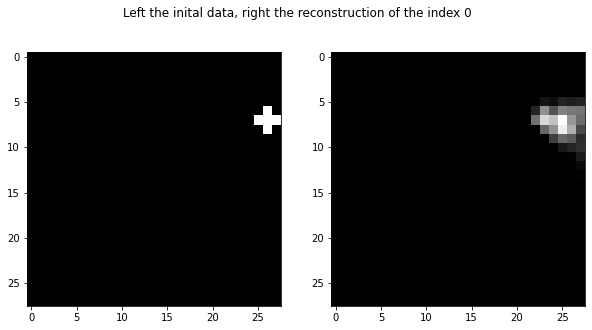

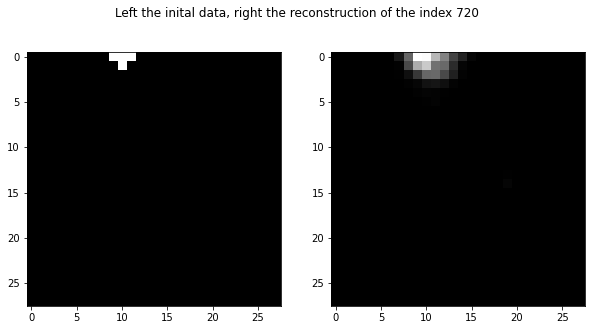

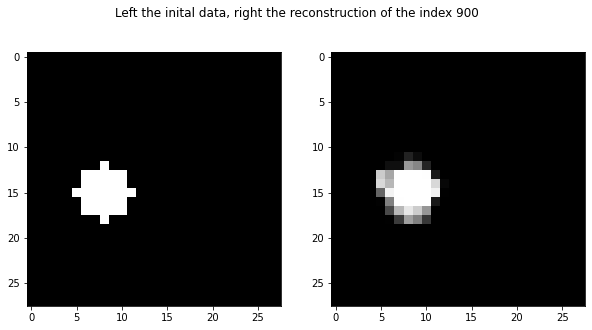

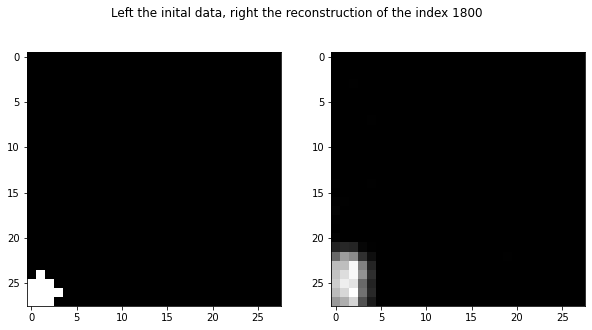

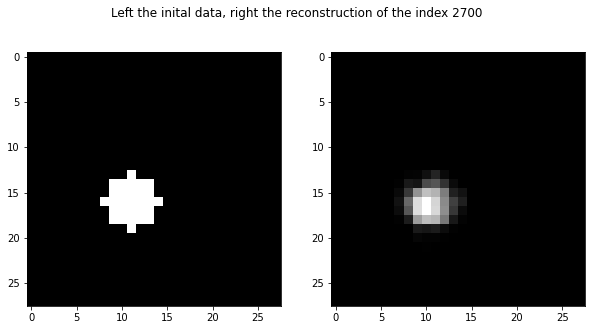

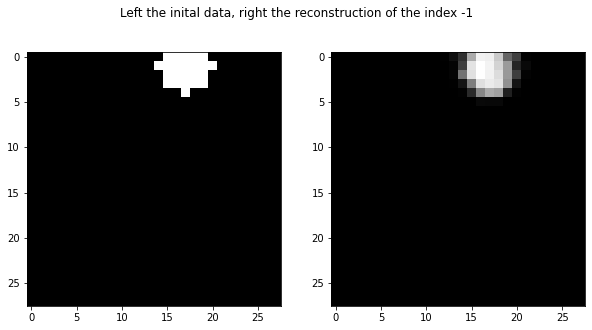

In [89]:
set_data = samples_test
for index in [0, len(set_data)//5, len(set_data)//4, len(set_data)//2, 3*len(set_data)//4, -1]:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Left the inital data, right the reconstruction of the index %s' % index)
    # plt.figure(figsize=(20, 10))
    ax[0].imshow(np.squeeze(set_data[index]), cmap='gray')
    ax[1].imshow(model(torch.tensor(set_data[index]).float().unsqueeze(0)).detach().numpy().squeeze(), cmap='gray')
    plt.show()